<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Model Development


### Inizializzazione

In [16]:
# Gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import os
import math
import shutil
import joblib
from scipy.special import comb
from collections import defaultdict
from sklearn.utils import shuffle

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

# Machine Learning e metriche
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    log_loss,
    f1_score,
    brier_score_loss,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
)

# Deep Learning con Keras e TensorFlow
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Concatenate,
    Masking,
    Embedding,
    Dropout,
    concatenate,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences

# Scaler fixed for non binary values
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
from xgboost import XGBClassifier

In [17]:
dataset = pd.read_csv("cleaned_dataset.csv")

dataset

,is_final,final_set,opponent_final_set,player_points,set_result,last_comeback,points_diff,points_length
0,1,0,0,"[0, 0, 1, 1, 0, 1, 1]",0,2,1,7
1,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",0,-1,0,8
2,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",0,-2,-1,9
3,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",0,1,0,10
4,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",0,2,1,11
...,...,...,...,...,...,...,...,...
489295,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",0,-5,-3,9
489296,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]",0,1,-3,11
489297,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",0,2,-2,12
489298,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0,-1,-3,13


In [18]:
def calcola_half_diff_punti(dataset):
    # Liste per memorizzare i risultati
    points_diff_half = []

    # Itera sulle sequenze di punti del dataset
    for points in dataset['player_points']:
        # Interpreta i punti come lista Python (se necessario)
        if isinstance(points, str):
            points = ast.literal_eval(points)

        punti_a = punti_b = 0

        # Lunghezza della sequenza
        length = len(points)

        # Calcola il punto di inizio (metà della sequenza)
        start_index = length // 2

        # Itera dalla metà della sequenza alla fine
        for point in points[start_index:]:
            if point == 1:
                punti_a += 1
            elif point == 0:
                punti_b += 1

        # Calcola la differenza e aggiungila alla lista
        points_diff_half.append(punti_a - punti_b)

    # Aggiungi la nuova colonna al dataset
    dataset = dataset.assign(
        points_diff_half=points_diff_half,
    )

    return dataset


# Applicare la funzione al tuo dataset
dataset = calcola_half_diff_punti(dataset)
dataset


,is_final,final_set,opponent_final_set,player_points,set_result,last_comeback,points_diff,points_length,points_diff_half
0,1,0,0,"[0, 0, 1, 1, 0, 1, 1]",0,2,1,7,2
1,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",0,-1,0,8,0
2,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",0,-2,-1,9,-1
3,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",0,1,0,10,1
4,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",0,2,1,11,2
...,...,...,...,...,...,...,...,...,...
489295,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",0,-5,-3,9,-5
489296,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]",0,1,-3,11,-4
489297,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",0,2,-2,12,-2
489298,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0,-1,-3,13,-3


In [20]:
def calcola_sequenza_positiva_negativa(dataset):
    # Lista per memorizzare le nuove sequenze
    positive_negative_sequences = []

    # Itera sulle sequenze di punti del dataset
    for points in dataset['player_points']:
        if isinstance(points, str):
            points = ast.literal_eval(points)

        # Lista per memorizzare la nuova sequenza
        sequence = []

        # Genera la nuova sequenza
        for i, point in enumerate(points, start=1):
            if point == 1:
                sequence.append(i)
            elif point == 0:
                sequence.append(-i)

        positive_negative_sequences.append(sequence)

    # Aggiungi la nuova colonna al dataset
    dataset = dataset.assign(
        positive_negative_sequence=positive_negative_sequences,
    )

    return dataset

dataset = calcola_sequenza_positiva_negativa(dataset)
dataset

,is_final,final_set,opponent_final_set,player_points,set_result,last_comeback,points_diff,points_length,points_diff_half,positive_negative_sequence
0,1,0,0,"[0, 0, 1, 1, 0, 1, 1]",0,2,1,7,2,"[-1, -2, 3, 4, -5, 6, 7]"
1,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0]",0,-1,0,8,0,"[-1, -2, 3, 4, -5, 6, 7, -8]"
2,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0]",0,-2,-1,9,-1,"[-1, -2, 3, 4, -5, 6, 7, -8, -9]"
3,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1]",0,1,0,10,1,"[-1, -2, 3, 4, -5, 6, 7, -8, -9, 10]"
4,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1]",0,2,1,11,2,"[-1, -2, 3, 4, -5, 6, 7, -8, -9, 10, 11]"
...,...,...,...,...,...,...,...,...,...,...
489295,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0]",0,-5,-3,9,-5,"[1, 2, -3, 4, -5, -6, -7, -8, -9]"
489296,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]",0,1,-3,11,-4,"[1, 2, -3, 4, -5, -6, -7, -8, -9, -10, 11]"
489297,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]",0,2,-2,12,-2,"[1, 2, -3, 4, -5, -6, -7, -8, -9, -10, 11, 12]"
489298,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0,-1,-3,13,-3,"[1, 2, -3, 4, -5, -6, -7, -8, -9, -10, 11, 12,..."


## Funzioni training split

Funzione che procede alla eliminazione dei folder quando è necessario

Suddivisione del dataset iniziale in numerosi dataset sulla base delle istanze dei punteggi

In [ ]:
# Funzione per calcolare la combinazione di punteggi
def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"

# Funzione per creare i dataset separati in base alla combinazione di punteggi
def create_datasets_by_score_combinations(df):
    # Applica la funzione `extract_scores` per ottenere le combinazioni di punteggi
    score_combinations = df['player_points'].apply(extract_scores)

    # Inizializza un dizionario per memorizzare i dataset
    datasets = defaultdict(list)

    # Raggruppa le righe in base alla combinazione di punteggi
    for index, row in df.iterrows():
        score_combination = score_combinations[index]
        datasets[score_combination].append(row)

    # Crea un dataframe per ogni combinazione di punteggi
    result_datasets = {}
    for score_combination, rows in datasets.items():
        result_datasets[score_combination] = pd.DataFrame(rows)

    return result_datasets

# Funzione per salvare i dataset in una cartella
def save_datasets_to_folder(datasets, folder_path):
    # Crea la cartella se non esiste
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Salva ogni dataset in un file CSV
    for score_combination, dataset in datasets.items():
        # Conta il numero di righe nel dataset
        num_rows = len(dataset)

        # Usa "dataset_" come prefisso e la combinazione di punteggi come parte del nome
        filename = f"{score_combination}.csv"
        filepath = os.path.join(folder_path, filename)

        # Salva il dataset nel file CSV
        dataset.to_csv(filepath, index=False)


# Esegui la funzione sul dataset
result_datasets = create_datasets_by_score_combinations(dataset)

# Specifica la cartella dove salvare i file
folder_path = '/content/datasets'

# Salva i dataset separati nella cartella
save_datasets_to_folder(result_datasets, folder_path)



Verifica dei numeri

In [ ]:
'''
def extract_scores(player_points):
    # Se player_points è una stringa, la converte in una lista
    if isinstance(player_points, str):
        player_points = ast.literal_eval(player_points)

    # Conta i punteggi di 1 e 0
    count_ones = player_points.count(1)
    count_zeros = player_points.count(0)

    return f"{count_ones}-{count_zeros}"
# Funzione principale che calcola e ritorna le combinazioni di punteggio
def count_score_combinations(dataframe):
    # Calcola le combinazioni senza aggiungerle al dataframe
    score_combinations = dataframe['player_points'].apply(extract_scores)

    # Conta le occorrenze di ciascuna combinazione
    return score_combinations.value_counts()

# Calcolo e stampa delle combinazioni
score_count = count_score_combinations(dataset)
print(score_count)
'''

'\ndef extract_scores(player_points):\n    # Se player_points è una stringa, la converte in una lista\n    if isinstance(player_points, str):\n        player_points = ast.literal_eval(player_points)\n\n    # Conta i punteggi di 1 e 0\n    count_ones = player_points.count(1)\n    count_zeros = player_points.count(0)\n\n    return f"{count_ones}-{count_zeros}"\n# Funzione principale che calcola e ritorna le combinazioni di punteggio\ndef count_score_combinations(dataframe):\n    # Calcola le combinazioni senza aggiungerle al dataframe\n    score_combinations = dataframe[\'player_points\'].apply(extract_scores)\n\n    # Conta le occorrenze di ciascuna combinazione\n    return score_combinations.value_counts()\n\n# Calcolo e stampa delle combinazioni\nscore_count = count_score_combinations(dataset)\nprint(score_count)\n'

In [ ]:
# Funzione per fare il train-test split sui file CSV
def split_train_test_for_csv_files(input_folder, output_folder, test_size=0.2, random_state=42):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella di input
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            # Costruisci il percorso completo del file CSV
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV in un DataFrame
            df = pd.read_csv(file_path)

            # Suddividi il dataset in training e test (80/20)
            train_data, test_data = train_test_split(df, test_size=test_size, random_state=random_state)

            # Crea i nomi dei file per il training e il test
            train_filename = file_name.replace(".csv", "_train.csv")
            test_filename = file_name.replace(".csv", "_test.csv")

            # Costruisci i percorsi per i file di training e test
            train_filepath = os.path.join(output_folder, train_filename)
            test_filepath = os.path.join(output_folder, test_filename)

            # Salva i dati di training e test in nuovi file CSV
            train_data.to_csv(train_filepath, index=False)
            test_data.to_csv(test_filepath, index=False)
            '''
            # Stampa il risultato
            print(f"File '{file_name}' diviso in {train_filename} e {test_filename}.")
            print(f"  - {len(train_data)} righe per il training.")
            print(f"  - {len(test_data)} righe per il test.")
            '''

# Esegui la funzione per suddividere i dataset
input_folder = '/content/datasets'  # Cartella dove sono i file CSV originali
output_folder = '/content/split_datasets'  # Cartella dove salvare i file divisi

split_train_test_for_csv_files(input_folder, output_folder)


In [ ]:
# Funzione per creare il dataset "opposite" (opponent) modificato
def create_opponent_dataset(df):
    # Copia del dataframe originale per non modificarlo direttamente
    opponent_df = df.copy()

    # 1. Scambia 'final_set' e 'opponent_final_set'
    opponent_df['final_set'], opponent_df['opponent_final_set'] = opponent_df['opponent_final_set'], opponent_df['final_set']

    # 2. Scambia i valori in 'player_points'
    opponent_df['player_points'] = opponent_df['player_points'].apply(lambda points: [1 - p for p in ast.literal_eval(points)])

    # 3. Scambia 'set_result' (0 diventa 1 e viceversa)
    opponent_df['set_result'] = opponent_df['set_result'].apply(lambda x: 1 - x)

    # 4. Inverti 'last_come_back' e 'point_diff' (positivi diventano negativi e viceversa)
    opponent_df['last_comeback'] = opponent_df['last_comeback'].apply(lambda x: -x)
    opponent_df['points_diff'] = opponent_df['points_diff'].apply(lambda x: -x)

    return opponent_df

# Funzione per caricare e modificare i dataset separati in training e test
def create_opponent_datasets(input_folder, output_folder):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella di input
    for file_name in os.listdir(input_folder):
        if file_name.endswith("_train.csv") or file_name.endswith("_test.csv"):
            # Costruisci il percorso completo del file CSV
            file_path = os.path.join(input_folder, file_name)

            # Leggi il file CSV in un DataFrame
            df = pd.read_csv(file_path)

            # Crea il dataset "opponent"
            opponent_df = create_opponent_dataset(df)

            # Estrai il punteggio dal nome del file (ad esempio '5-3_train.csv' -> '5-3')
            base_name = file_name.split('_')[0]  # '5-3' da '5-3_train.csv'

            # Inverti i numeri (ad esempio '5-3' -> '3-5')
            inverted_score = '-'.join(base_name.split('-')[::-1])  # '5-3' -> '3-5'

            # Crea il nuovo nome del file aggiungendo '_opp'
            opponent_filename = f"{inverted_score}_train_opp.csv" if "_train" in file_name else f"{inverted_score}_test_opp.csv"

            # Percorso completo del nuovo file
            opponent_filepath = os.path.join(output_folder, opponent_filename)

            # Salva il nuovo dataset "opponent"
            opponent_df.to_csv(opponent_filepath, index=False)

# Esegui la funzione per creare i dataset "opponent"
input_folder = '/content/split_datasets'  # Cartella con i file CSV separati per training e test
output_folder = '/content/opponent_datasets'  # Cartella dove salvare i file trasformati

create_opponent_datasets(input_folder, output_folder)



In [ ]:

# Funzione per unire i dataset originali con quelli "opponent"
def merge_datasets(original_folder, opponent_folder, output_folder):
    # Verifica se la cartella di output esiste, altrimenti la crea
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ottieni tutti i file CSV dalla cartella degli originali (train e test)
    original_train_files = {f.replace("_train.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_train.csv")}
    opponent_train_files = {f.replace("_train_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_train_opp.csv")}

    original_test_files = {f.replace("_test.csv", ""): f for f in os.listdir(original_folder) if f.endswith("_test.csv")}
    opponent_test_files = {f.replace("_test_opp.csv", ""): f for f in os.listdir(opponent_folder) if f.endswith("_test_opp.csv")}

    # Unisci i file per il training
    for base_name, original_file in original_train_files.items():
        opponent_file = opponent_train_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            # Leggi i file CSV in DataFrame
            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            # Unisci i due DataFrame
            merged_train_df = pd.concat([original_df, opponent_df], ignore_index=True)

            # Salva il nuovo dataset unito
            merged_train_filename = f"merged_{original_file}"
            merged_train_filepath = os.path.join(output_folder, merged_train_filename)
            merged_train_df.to_csv(merged_train_filepath, index=False)

            # Stampa il risultato
            print(f"Unito '{original_file}' e '{opponent_file}' in '{merged_train_filename}'.")

    # Unisci i file per il test
    for base_name, original_file in original_test_files.items():
        opponent_file = opponent_test_files.get(base_name)

        if opponent_file:
            original_path = os.path.join(original_folder, original_file)
            opponent_path = os.path.join(opponent_folder, opponent_file)

            # Leggi i file CSV in DataFrame
            original_df = pd.read_csv(original_path)
            opponent_df = pd.read_csv(opponent_path)

            # Unisci i due DataFrame
            merged_test_df = pd.concat([original_df, opponent_df], ignore_index=True)

            # Salva il nuovo dataset unito
            merged_test_filename = f"merged_{original_file}"
            merged_test_filepath = os.path.join(output_folder, merged_test_filename)
            merged_test_df.to_csv(merged_test_filepath, index=False)

# Esegui la funzione per unire i dataset
original_folder = '/content/split_datasets'  # Cartella con i file originali (train e test)
opponent_folder = '/content/opponent_datasets'  # Cartella con i file degli opponent (train_opp e test_opp)
output_folder = '/content/merged_datasets'  # Cartella dove salvare i file uniti

merge_datasets(original_folder, opponent_folder, output_folder)


Unito '5-8_train.csv' e '5-8_train_opp.csv' in 'merged_5-8_train.csv'.
Unito '9-7_train.csv' e '9-7_train_opp.csv' in 'merged_9-7_train.csv'.
Unito '6-7_train.csv' e '6-7_train_opp.csv' in 'merged_6-7_train.csv'.
Unito '7-8_train.csv' e '7-8_train_opp.csv' in 'merged_7-8_train.csv'.
Unito '5-3_train.csv' e '5-3_train_opp.csv' in 'merged_5-3_train.csv'.
Unito '4-6_train.csv' e '4-6_train_opp.csv' in 'merged_4-6_train.csv'.
Unito '9-9_train.csv' e '9-9_train_opp.csv' in 'merged_9-9_train.csv'.
Unito '9-8_train.csv' e '9-8_train_opp.csv' in 'merged_9-8_train.csv'.
Unito '4-5_train.csv' e '4-5_train_opp.csv' in 'merged_4-5_train.csv'.
Unito '8-9_train.csv' e '8-9_train_opp.csv' in 'merged_8-9_train.csv'.
Unito '8-7_train.csv' e '8-7_train_opp.csv' in 'merged_8-7_train.csv'.
Unito '5-7_train.csv' e '5-7_train_opp.csv' in 'merged_5-7_train.csv'.
Unito '3-6_train.csv' e '3-6_train_opp.csv' in 'merged_3-6_train.csv'.
Unito '7-9_train.csv' e '7-9_train_opp.csv' in 'merged_7-9_train.csv'.
Unito 

In [ ]:
import glob

# Specifica il percorso della cartella contenente i dataset
folder_path = 'merged_datasets'

# Usa glob per raccogliere tutti i file che terminano con '_train.csv'
file_pattern = os.path.join(folder_path, '*_train.csv')
all_files = glob.glob(file_pattern)

# Inizializza una lista per memorizzare i dataframe
dfs = []

# Leggi e aggiungi ogni file CSV alla lista
for file in all_files:
    df = pd.read_csv(file)  # Carica il dataset
    dfs.append(df)  # Aggiungi il dataframe alla lista

# Unisci tutti i dataframe in un unico grande dataframe
merged_df = pd.concat(dfs, ignore_index=True)

# Salva il dataframe unito in un nuovo file CSV
merged_df.to_csv('training_set.csv', index=False)

print('Datasets merged successfully!')

Datasets merged successfully!


In [ ]:
'''
# Specifica il percorso del file
folder_path = '/content/merged_datasets'
file_name = 'merged_6-4_train.csv'
file_path = os.path.join(folder_path, file_name)

# Verifica se il file esiste
if os.path.exists(file_path):
    # Leggi il dataset con Pandas
    df = pd.read_csv(file_path)

    # Converte la colonna 'player_points' in una lista di numeri (se non lo è già)
    def clean_player_points(value):
        if isinstance(value, str):
            # Interpreta la stringa come una lista
            return ast.literal_eval(value)
        return value  # Se è già una lista, restituisci com'è

    df['player_points'] = df['player_points'].apply(clean_player_points)

    # Dizionario per tracciare le istanze uniche
    instance_stats = {}

    # Itera sulle righe del DataFrame
    for _, row in df.iterrows():
        # Converti 'player_points' in una tupla per renderla hashabile
        player_points = tuple(row['player_points'])  # Converti in tupla
        set_result = row['set_result']  # Valore di 'set_result'

        # Se l'istanza non è ancora nel dizionario, inizializzala
        if player_points not in instance_stats:
            instance_stats[player_points] = {'tot': 0, 'win': 0}

        # Aggiorna il conteggio totale
        instance_stats[player_points]['tot'] += 1

        # Aggiorna il conteggio delle vittorie se 'set_result' è 1
        if set_result == 1:
            instance_stats[player_points]['win'] += 1

    # Creazione di un DataFrame per visualizzare i risultati
    result_data = [
        {
            'player_points': str(list(points)),  # Converti la tupla in lista e poi in stringa
            'tot': stats['tot'],
            'win': stats['win'],
            'win/tot': stats['win'] / stats['tot']  # Calcola la probabilità di vittoria
        }
        for points, stats in instance_stats.items()
    ]
    result_df = pd.DataFrame(result_data)

    # Ordina il DataFrame in base alla colonna 'win/tot' (probabilità di vittoria)
    result_df = result_df.sort_values(by='win/tot', ascending=True)  # ordina dal più basso al più alto

    # Configura Pandas per mostrare tutte le colonne e disabilitare la troncatura
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)  # Mostra tutto il contenuto delle celle

    # Stampa i risultati
    print("Risultati delle istanze uniche con totali, vittorie e probabilità di vittoria (ordinati per probabilità crescente):")
    print(result_df)
else:
    print(f"File non trovato: {file_path}")
'''

'\n# Specifica il percorso del file\nfolder_path = \'/content/merged_datasets\'\nfile_name = \'merged_6-4_train.csv\'\nfile_path = os.path.join(folder_path, file_name)\n\n# Verifica se il file esiste\nif os.path.exists(file_path):\n    # Leggi il dataset con Pandas\n    df = pd.read_csv(file_path)\n\n    # Converte la colonna \'player_points\' in una lista di numeri (se non lo è già)\n    def clean_player_points(value):\n        if isinstance(value, str):\n            # Interpreta la stringa come una lista\n            return ast.literal_eval(value)\n        return value  # Se è già una lista, restituisci com\'è\n\n    df[\'player_points\'] = df[\'player_points\'].apply(clean_player_points)\n\n    # Dizionario per tracciare le istanze uniche\n    instance_stats = {}\n\n    # Itera sulle righe del DataFrame\n    for _, row in df.iterrows():\n        # Converti \'player_points\' in una tupla per renderla hashabile\n        player_points = tuple(row[\'player_points\'])  # Converti in tupl

In [ ]:
import os
import shutil

def sposta_e_rinomina_file():
    # Nome della cartella originale e della nuova cartella
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_test"

    # Crea la cartella "dataset_test" se non esiste
    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    # Itera su tutti i file nella cartella originale
    for file_name in os.listdir(cartella_originale):
        # Controlla se il file è un "test"
        if "test" in file_name:
            # Nuovo nome del file senza il prefisso "merged_"
            nuovo_nome = file_name.replace("merged_", "")
            # Percorso completo del file originale e del file spostato
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            # Sposta e rinomina il file
            shutil.move(percorso_originale, percorso_nuovo)


# Esegui la funzione
sposta_e_rinomina_file()

In [ ]:
import os
import shutil

def sposta_e_rinomina_file():
    # Nome della cartella originale e della nuova cartella
    cartella_originale = "merged_datasets"
    cartella_test = "dataset_train"

    # Crea la cartella "dataset_train" se non esiste
    if not os.path.exists(cartella_test):
        os.makedirs(cartella_test)

    # Itera su tutti i file nella cartella originale
    for file_name in os.listdir(cartella_originale):
        # Controlla se il file è un "test"
        if "train" in file_name:
            # Nuovo nome del file senza il prefisso "merged_"
            nuovo_nome = file_name.replace("merged_", "")
            # Percorso completo del file originale e del file spostato
            percorso_originale = os.path.join(cartella_originale, file_name)
            percorso_nuovo = os.path.join(cartella_test, nuovo_nome)
            # Sposta e rinomina il file
            shutil.move(percorso_originale, percorso_nuovo)


# Esegui la funzione
sposta_e_rinomina_file()

In [ ]:
# 1. Funzione per caricare e combinare tutti i file .csv in un unico DataFrame
def load_and_combine_files(file_paths):
    test_data = []
    for file in file_paths:
        df = pd.read_csv(file)
        test_data.append(df)
    return pd.concat(test_data, ignore_index=True)

# 2. Ottieni i percorsi di tutti i file .csv nella cartella 'dataset_test'
test_files = [os.path.join('dataset_test', f) for f in os.listdir('dataset_test') if f.endswith('.csv')]

# 3. Carica e combina tutti i file in un unico DataFrame
combined_test_data = load_and_combine_files(test_files)

# 4. Salva il DataFrame combinato in un nuovo file CSV
combined_test_data.to_csv('test_set.csv', index=False)

print("File combinato salvato come 'test_set.csv'")

File combinato salvato come 'test_set.csv'


In [ ]:
def calculate_difference(filename):
    # Estrae i numeri dal nome del file, ad esempio "9-9_train.csv"
    parts = filename.split('_')[0].split('-')
    num1 = int(parts[0])
    num2 = int(parts[1])

    # Calcola la differenza assoluta
    return abs(num1 - num2)

def merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder):
    # Crea dizionari per accumulare i DataFrame per ogni differenza
    train_diff_dfs = {i: [] for i in range(4)}  # Differenze da 0 a 3
    test_diff_dfs = {i: [] for i in range(4)}

    # Leggi tutti i file da dataset_train
    train_files = [f for f in os.listdir(dataset_train_path) if f.endswith('.csv')]

    # Unisci i dataset in base alla differenza per il training set
    for file in train_files:
        diff = calculate_difference(file)  # Calcola la differenza assoluta
        if diff <= 3:  # Considera solo differenze da 0 a 3
            df = pd.read_csv(os.path.join(dataset_train_path, file))  # Carica il dataset
            train_diff_dfs[diff].append(df)  # Aggiungi il DataFrame alla lista corrispondente

    # Leggi tutti i file da dataset_test
    test_files = [f for f in os.listdir(dataset_test_path) if f.endswith('.csv')]

    # Unisci i dataset in base alla differenza per il test set
    for file in test_files:
        diff = calculate_difference(file)  # Calcola la differenza assoluta
        if diff <= 3:  # Considera solo differenze da 0 a 3
            df = pd.read_csv(os.path.join(dataset_test_path, file))  # Carica il dataset
            test_diff_dfs[diff].append(df)  # Aggiungi il DataFrame alla lista corrispondente

    # Crea le cartelle di destinazione per i nuovi dataset uniti
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    # Salva i DataFrame uniti per ogni differenza nei rispettivi file CSV
    for diff in range(4):
        if train_diff_dfs[diff]:
            # Unisci tutti i DataFrame della stessa differenza
            train_merged = pd.concat(train_diff_dfs[diff], ignore_index=True)
            train_merged.to_csv(os.path.join(output_train_folder, f"dataset_train_diff_{diff}.csv"), index=False)

        if test_diff_dfs[diff]:
            # Unisci tutti i DataFrame della stessa differenza
            test_merged = pd.concat(test_diff_dfs[diff], ignore_index=True)
            test_merged.to_csv(os.path.join(output_test_folder, f"dataset_test_diff_{diff}.csv"), index=False)

# Percorsi delle cartelle
dataset_train_path = '/content/dataset_train'
dataset_test_path = '/content/dataset_test'

# Cartelle di destinazione per i nuovi dataset uniti
output_train_folder = '/content/dataset_train_diff'
output_test_folder = '/content/dataset_test_diff'

# Unisci e salva i dataset
merge_and_save_datasets_by_difference(dataset_train_path, dataset_test_path, output_train_folder, output_test_folder)

print("Unione e salvataggio dei dataset completati con successo.")


Unione e salvataggio dei dataset completati con successo.


In [ ]:
# Funzione per eliminare cartelle specificate
def delete_folders(folders):
    for folder in folders:
        if os.path.exists(folder):
            try:
                shutil.rmtree(folder)  # Rimuove la cartella e tutto il suo contenuto
                print(f"La cartella '{folder}' è stata eliminata.")
            except Exception as e:
                print(f"Errore durante l'eliminazione della cartella '{folder}': {e}")
        else:
            print(f"La cartella '{folder}' non esiste.")

# Lista delle cartelle da eliminare
folders_to_delete = ['/content/datasets', '/content/split_datasets', '/content/opponent_datasets','/content/merged_datasets']

# Esegui la funzione per eliminare le cartelle
delete_folders(folders_to_delete)


La cartella '/content/datasets' è stata eliminata.
La cartella '/content/split_datasets' è stata eliminata.
La cartella '/content/opponent_datasets' è stata eliminata.
La cartella '/content/merged_datasets' è stata eliminata.


# Training modelli

In [ ]:
training_set = pd.read_csv("training_set.csv")
training_set = training_set.sample(frac=1, random_state=42).reset_index(drop=True)

test_set = pd.read_csv("test_set.csv")
test_set = test_set.sample(frac=1, random_state=42).reset_index(drop=True)

dataset = pd.concat([training_set, test_set], ignore_index=True)
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
columns = ['is_final', 'final_set', 'opponent_final_set','last_comeback', 'points_diff', 'points_length']

X_train = training_set[columns].values

Y_train = training_set['set_result'].values

X_test =  test_set[columns].values

Y_test = test_set['set_result'].values

In [ ]:
# Prepara i dati (scaling)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest

In [ ]:
# Crea il modello di Random Forest
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_scaled, Y_train)

RandomForestClassifier(random_state=42)

### Logistic Regression

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

### LSTM

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

In [ ]:
'''
Da usare alla fine quando abbiamo finito il training e il testing e quindi vogliamo avere il modello finale

# Carica i dati dal dataset (presumibilmente già caricati come training_set)
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['is_final', 'final_set', 'opponent_final_set']])

# Converti ogni stringa in una lista di interi
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]

# Padding delle sequenze
max_sequence_length = 18  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points_converted , maxlen=max_sequence_length, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result
'''

In [ ]:
# Creazione del set di training

# Carica i dati dal dataset (presumibilmente già caricati come training_set)
player_points = np.array(training_set['player_points'].values)
set_result = np.array(training_set['set_result'].values)
global_features = np.array(training_set[['is_final', 'final_set', 'opponent_final_set']])

# Converti ogni stringa in una lista di interi
player_points_converted = [eval(seq) if isinstance(seq, str) else seq for seq in player_points]

# Padding delle sequenze
max_sequence_length = 18  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points_converted , maxlen=max_sequence_length, padding='post', truncating='post', value=-1)


X_train_seq = player_points_padded
X_train_global = global_features
Y_train = set_result

In [ ]:
# Creazione del set di test

# Carica i dati dal dataset (presumibilmente già caricati come test_set)
player_points_test = np.array(test_set['player_points'].values)
set_result_test = np.array(test_set['set_result'].values)
global_features_test = np.array(test_set[['is_final', 'final_set', 'opponent_final_set']])

# Converti ogni stringa in una lista di interi
player_points_converted_test = [eval(seq) if isinstance(seq, str) else seq for seq in player_points_test]

player_points_padded_test = pad_sequences(player_points_converted_test, maxlen=18, padding='post', truncating='post', value=-1)

X_test_seq = player_points_padded_test
X_test_global = global_features_test
Y_test = set_result_test

In [ ]:
'''
Testare il modello LSTM e vedere se è possibile migliorare gli iperparametri
'''
# Preparazione dei dati per l'input del modello

# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')

# Embedding con 3 possibili valori di input (es. 0, 1, -1) e vettori di dimensione 32.
x = Embedding(input_dim=3, output_dim=16)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(3,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])

# Aggiungi Dropout per ridurre l'overfitting
x = Dropout(0.3)(combined)

# Strato denso con 32 unità per la combinazione.
x = Dense(32, activation='relu')(x)

# Output del modello con attivazione sigmoide per classificazione binaria
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello LSTM(Provare anche con 20 epoche)
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

Epoch 1/5
6116/6116 ━━━━━━━━━━━━━━━━━━━━ 253s 41ms/step - accuracy: 0.6974 - loss: 0.5804
Epoch 2/5
6116/6116 ━━━━━━━━━━━━━━━━━━━━ 277s 43ms/step - accuracy: 0.7065 - loss: 0.5698
Epoch 3/5
6116/6116 ━━━━━━━━━━━━━━━━━━━━ 343s 46ms/step - accuracy: 0.7074 - loss: 0.5696
Epoch 4/5
6116/6116 ━━━━━━━━━━━━━━━━━━━━ 331s 48ms/step - accuracy: 0.7071 - loss: 0.5686
Epoch 5/5
6116/6116 ━━━━━━━━━━━━━━━━━━━━ 309s 46ms/step - accuracy: 0.7082 - loss: 0.5677


In [ ]:
lstm_model.save('LSTM2.keras')

In [ ]:
lstm_model = tf.keras.models.load_model('LSTM1.keras')

### LSTM VS Logistic Regression

In [ ]:
# Funzione per calcolare le metriche richieste per un singolo modello
def evaluate_model(model, X_test, Y_test):
    # Predizioni per accuracy (probabilità massima per classi binarie)
    y_pred = model.predict_proba(X_test)[:, 1]  # Ottieni le probabilità della classe positiva (1)

    # Calcolare l'accuratezza
    log_loss_value = log_loss(Y_test, y_pred)
    brier_score_value = brier_score_loss(Y_test, y_pred)

    # Restituisci le metriche
    return {
        'Brier Score': brier_score_value,
        'Log Loss': log_loss_value,
    }

# Lista dei modelli (un solo modello in questo caso)
model = log_reg  # Usa il modello che hai definito (log_reg)

# Esegui la valutazione del modello
results = evaluate_model(model, X_test_scaled, Y_test)

# Stampa i risultati
print(f"Model: {model}")
print(f"Brier Score: {results['Brier Score']:.4f}")
print(f"Log Loss: {results['Log Loss']:.4f}")

Model: LogisticRegression(max_iter=1000, random_state=42)
Brier Score: 0.1918
Log Loss: 0.5669


In [ ]:
# Previsioni probabilistiche per il set di test
y_pred_prob = lstm_model.predict([X_test_seq, X_test_global])

# Calcolare il Log Loss
log_loss_value = log_loss(Y_test, y_pred_prob)

# Calcolare il Brier Score
brier_score_value = brier_score_loss(Y_test, y_pred_prob)

# Stampa dei risultati
print(f"Log Loss: {log_loss_value:.4f}")
print(f"Brier Score: {brier_score_value:.4f}")

6118/6118 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step
Log Loss: 0.5661
Brier Score: 0.1916


In [ ]:
### VALUTA LE PRESTAZIONI CON I SINGOLI FILE DI TEST PER OGNI PUNTEGGIO (LOGISTIC REGRESSION vs LSTM)
# Funzione per test personalizzato con un singolo modello

def testing_personalizzato(cartella_test, modelli, max_sequence_length, scaler=None):
    risultati = []

    # Itera su tutti i file nella cartella
    for file_name in os.listdir(cartella_test):
        if file_name.endswith(".csv"):
            # Carica i dati di test
            percorso_file = os.path.join(cartella_test, file_name)
            dataset_test = pd.read_csv(percorso_file)

            # Prepara le colonne comuni
            Y_test = dataset_test['set_result'].values

            # Ciclo sui modelli
            for modello in modelli:
                if modello == lstm_model:  # Preprocessing specifico per l'LSTM
                    # Prepara i dati per l'LSTM
                    player_points_test = dataset_test['player_points'].values
                    global_features_test = dataset_test[['is_final', 'final_set', 'opponent_final_set']].values

                    # Converti ogni stringa in una lista di interi
                    player_points_converted_test = [
                        eval(seq) if isinstance(seq, str) else seq for seq in player_points_test
                    ]

                    # Padded sequences
                    X_test_seq = pad_sequences(
                        player_points_converted_test,
                        maxlen=max_sequence_length,
                        padding='post',
                        truncating='post',
                        value=-1
                    )
                    X_test_global = global_features_test

                    # Predizioni
                    y_pred = modello.predict([X_test_seq, X_test_global], verbose=0).flatten()
                else:  # Preprocessing per modelli tradizionali (es. log_reg)
                    columns = ['is_final', 'final_set', 'opponent_final_set', 'last_comeback', 'points_diff', 'points_length']
                    X_test = dataset_test[columns].values

                    if scaler is not None:
                        X_test = scaler.transform(X_test)

                    # Predizioni
                    y_pred = modello.predict_proba(X_test)[:, 1]

                # Calcolo delle metriche
                log_loss_value = log_loss(Y_test, y_pred)
                brier_score_value = brier_score_loss(Y_test, y_pred)

                # Salva i risultati
                risultati.append({
                    'file': file_name,
                    'modello': modello.name if hasattr(modello, 'name') else str(modello),
                    'log_loss': log_loss_value,
                    'brier_score': brier_score_value
                })

    return risultati


# Definizione del ciclo di stampa finale
def stampa_risultati_confronto(risultati):
    for risultato in risultati:
        print(f"File: {risultato['file'][:3]}")
        print(f"Modello: {risultato['modello']}")
        print(f"Log Loss: {risultato['log_loss']:.4f}")
        print(f"Brier Score: {risultato['brier_score']:.4f}")
        print("-" * 50)


# Esegui il testing personalizzato
cartella_test = "dataset_test"
modelli = [log_reg, lstm_model]

# Supponendo che max_sequence_length sia 18
risultati_test = testing_personalizzato(cartella_test, modelli, 18, scaler=scaler)

# Stampa i risultati
#stampa_risultati_confronto(risultati_test)


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
146/146 ━━━━━━━━

In [ ]:
def calcola_punteggio(y_true, y_pred, y_pred_prob):
    punteggio_A = 0
    punteggio_B = 0

    for true, pred_A, pred_B in zip(y_true, y_pred, y_pred_prob):
        # Se entrambi i modelli predicono la stessa classe correttamente
        if true == 1:
            if pred_A > 0.5 and pred_B > 0.5:  # Entrambi predicono la classe 1
                if pred_A > pred_B:
                    punteggio_A += pred_A
                else:
                    punteggio_B += pred_B
        else:  # Classe 0
            if pred_A <= 0.5 and pred_B <= 0.5:  # Entrambi predicono la classe 0
                if (1 - pred_A) > (1 - pred_B):  # Utilizziamo la probabilità complementare
                    punteggio_A += (1 - pred_A)
                else:
                    punteggio_B += (1 - pred_B)

    return punteggio_A, punteggio_B



punteggio_A, punteggio_B = calcola_punteggio(Y_test, y_pred_prob, y_pred_prob)

print(f"Punteggio modello A: {punteggio_A}")
print(f"Punteggio modello B: {punteggio_B}")

if punteggio_A > punteggio_B:
    print("Il modello A è migliore!")
elif punteggio_A < punteggio_B:
    print("Il modello B è migliore!")
else:
    print("I due modelli sono uguali.")

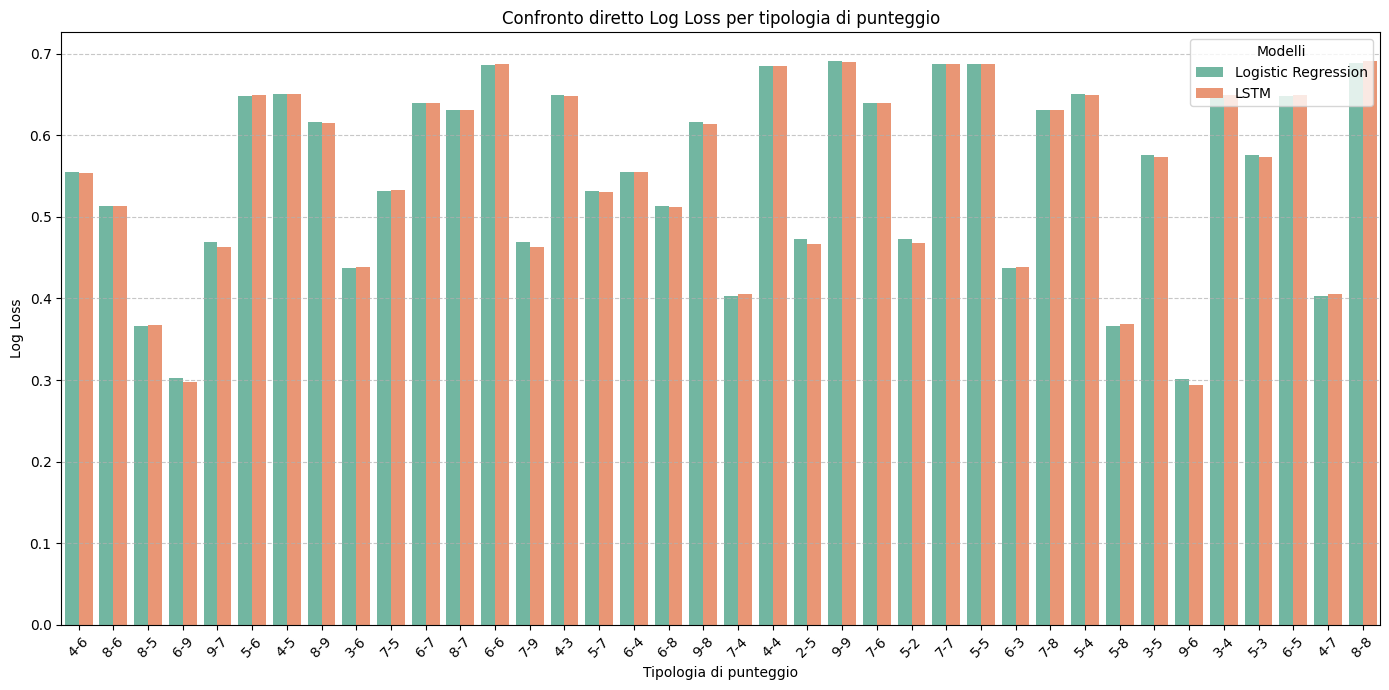

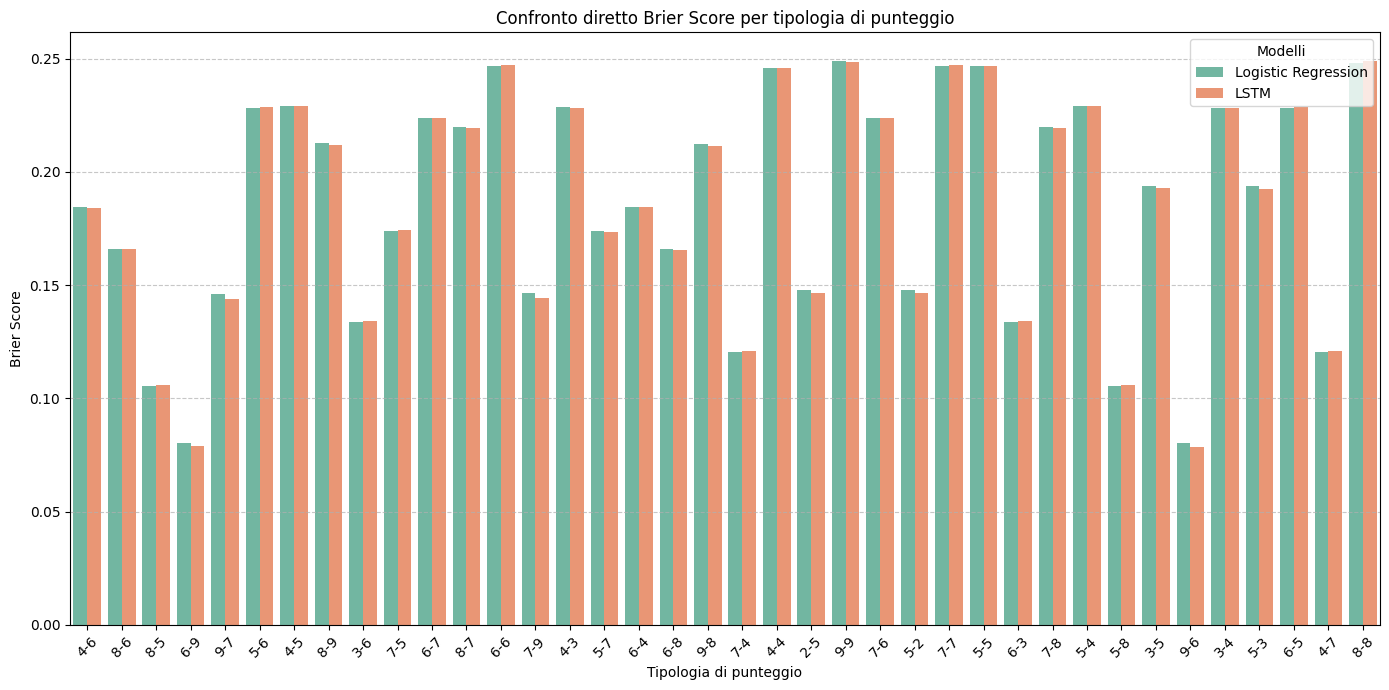

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def grafico_confronto_metriche(risultati):
    """
    Confronta le prestazioni di Logistic Regression e LSTM sui punteggi con un grafico a barre per Log Loss e Brier Score.

    Parametri:
        risultati (list of dict): Lista di risultati con 'file', 'modello', 'log_loss', 'brier_score'.
    """
    # Converti i risultati in un DataFrame
    df = pd.DataFrame(risultati)
    df['punteggio'] = df['file'].str[:3]  # Estrai il punteggio dal nome del file

    # Confronto diretto per Log Loss
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df,
        x='punteggio',
        y='log_loss',
        hue='modello',
        palette='Set2',
        errorbar='sd',  # Aggiungi l'intervallo di confidenza per la deviazione standard
        capsize=0.1  # Piccole estremità per la barra d'errore
    )
    plt.title("Confronto diretto Log Loss per tipologia di punteggio")
    plt.xlabel("Tipologia di punteggio")
    plt.ylabel("Log Loss")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Modifica della legenda
    handles, labels = plt.gca().get_legend_handles_labels()

    # Personalizzare le etichette della legenda
    # Sostituisci i nomi esistenti con quelli desiderati
    labels = ['Logistic Regression', 'LSTM']  # Esempio di nomi personalizzati

    # Personalizzare la posizione e titolo della legenda
    plt.legend(handles, labels, title="Modelli", loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

    # Confronto diretto per Brier Score
    plt.figure(figsize=(14, 7))
    sns.barplot(
        data=df,
        x='punteggio',
        y='brier_score',
        hue='modello',
        palette='Set2',
        errorbar='sd',  # Aggiungi l'intervallo di confidenza per la deviazione standard
        capsize=0.1  # Piccole estremità per la barra d'errore
    )
    plt.title("Confronto diretto Brier Score per tipologia di punteggio")
    plt.xlabel("Tipologia di punteggio")
    plt.ylabel("Brier Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Modifica della legenda
    handles, labels = plt.gca().get_legend_handles_labels()

    # Personalizzare le etichette della legenda
    # Sostituisci i nomi esistenti con quelli desiderati
    labels = ['Logistic Regression', 'LSTM']  # Esempio di nomi personalizzati

    # Personalizzare la posizione e titolo della legenda
    plt.legend(handles, labels, title="Modelli", loc='upper right', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

grafico_confronto_metriche(risultati_test)


6118/6118 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step


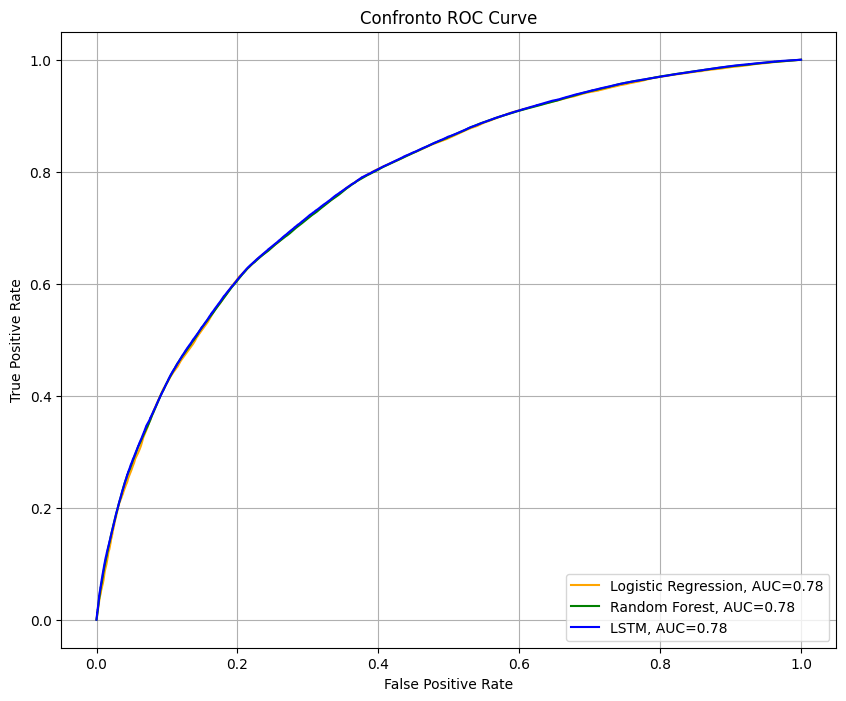

In [ ]:
# Inizializza i modelli
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "LSTM": lstm_model
}

# Genera colori per le curve
colors = ["orange", "green", "blue"]

plt.figure(figsize=(10, 8))

# Itera sui modelli e calcola la ROC curve
for (name, model), color in zip(models.items(), colors):
    if name == "LSTM":
        # Predizione per LSTM (con due input)
        y_pred_prob = lstm_model.predict([X_test_seq, X_test_global]).flatten()
    else:
        # Predizione per gli altri modelli
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Calcola la curva ROC
    fpr, tpr, _ = roc_curve(Y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Disegna la curva
    plt.plot(fpr, tpr, color=color, label=f"{name}, AUC={roc_auc:.2f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Confronto ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Performance Analysis

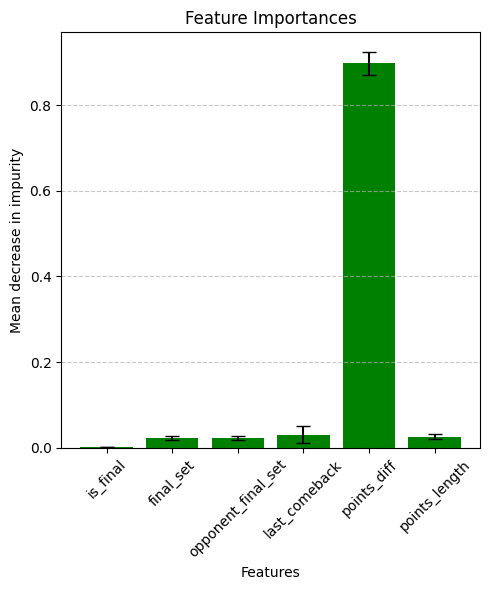

In [ ]:
X = np.array((dataset[['is_final', 'final_set', 'opponent_final_set', 'last_comeback', 'points_diff', 'points_length']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf2 = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

rf2.fit(X, Y)

# Nomi delle feature
feature_names = ['is_final', 'final_set', 'opponent_final_set', 'last_comeback', 'points_diff', 'points_length']


# Estrai le feature importance per ogni albero
tree_importances = np.array([tree.feature_importances_ for tree in rf2.estimators_])

# Calcola la media e la deviazione standard per ogni feature
mean_importances = tree_importances.mean(axis=0)
std_importances = tree_importances.std(axis=0)

plt.figure(figsize=(5, 6))
plt.bar(feature_names, mean_importances, yerr=std_importances, color="green", alpha=1, capsize=5)
plt.title("Feature Importances")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

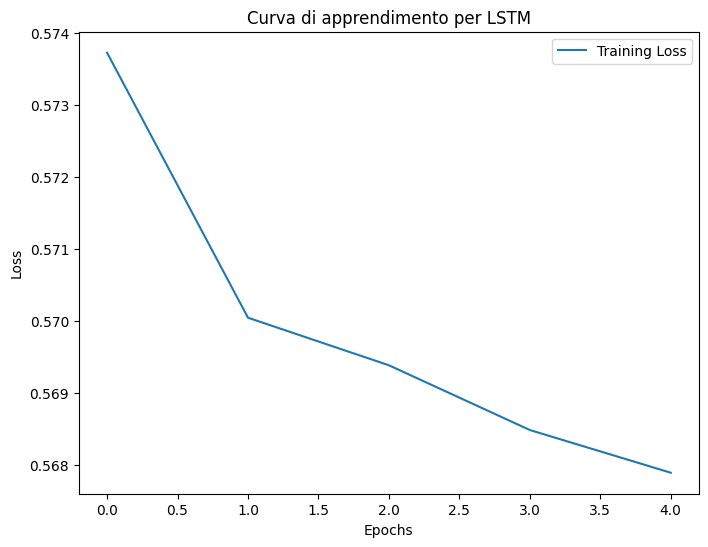

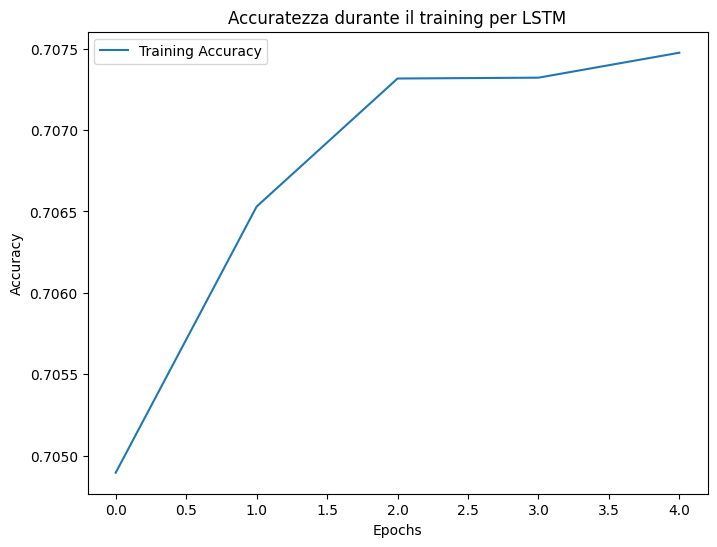

In [ ]:
# Grafico diminuzione della loss durante le poche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()

# Grafico miglioramento dell'accuratezza durante le epoche LSTM
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

6118/6118 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step


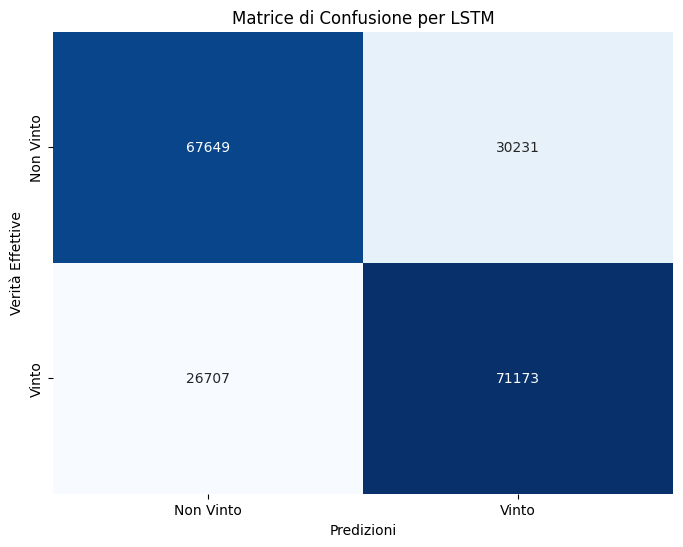

In [ ]:
#Calcolo matrice di confusione LSTM
# Predizione sui dati di test
y_pred = lstm_model.predict([X_test_seq, X_test_global])

# Poiché la funzione di attivazione dell'output è sigmoide, le predizioni sono probabilità.
# Per ottenere le etichette binarie, applica una soglia di 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Calcola la matrice di confusione
cm = confusion_matrix(Y_test, y_pred_binary)

# Stampa la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

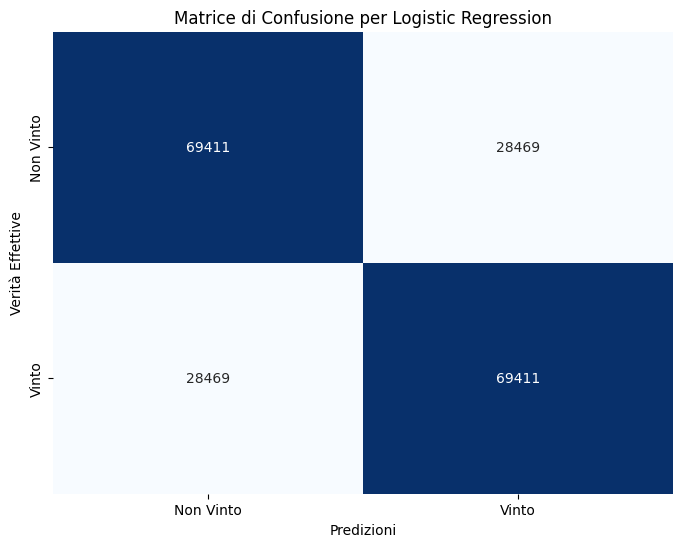

In [ ]:
#Calcolo matrice di confusione Logistic Regression
# Predizioni
y_pred = log_reg.predict(X_test_scaled)

# Calcola la matrice di confusione
cm = confusion_matrix(Y_test, y_pred)

# Stampa la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per Logistic Regression')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

In [ ]:
import itertools

def conta_valori_finali(vettore):
    # Partiamo dall'ultimo elemento e contiamo quante occorrenze troviamo
    ultimo_valore = vettore[-1]
    contatore = 0

    # Partiamo dall'ultimo elemento e contiamo finché il valore rimane lo stesso
    for val in reversed(vettore):
        if val == ultimo_valore:
            # Se l'ultimo valore è 1, contiamo in positivo, altrimenti in negativo
            if ultimo_valore == 1:
                contatore += 1
            elif ultimo_valore == 0:
                contatore -= 1
        else:
            break  # Fermiamoci quando troviamo un valore diverso

    return contatore


def genera_vettori(lstm_model, log_reg, features, n_top=5):
    # Creiamo un array con 6 1 e 4 0
    base = [1] * 6 + [0] * 4

    # Otteniamo tutte le permutazioni uniche del vettore base
    permutazioni = set(itertools.permutations(base))

    # Liste per memorizzare le predizioni e le probabilità
    lstm_predictions = []
    log_reg_predictions = []

    # Iteriamo su tutte le permutazioni uniche
    for vettore in permutazioni:
        # Convertiamo la tupla in una lista (opzionale)
        sequenza = list(vettore)

        # Prepara il formato dei dati per il modello LSTM
        X_lstm = np.array([sequenza])  # Se LSTM richiede 2D (sequenza, features)
        X_lstm = pad_sequences(X_lstm, maxlen=18, padding='post', truncating='post', value=-1)
        # Chiamata alla predizione del modello LSTM
        y_pred_prob = lstm_model.predict([X_lstm, features], verbose=0)  # Verifica come passare `features`

        # Deriviamo le features dalla sequenza per log_reg
        num_1 = sequenza.count(1)
        num_0 = sequenza.count(0)
        total = len(sequenza)  # Questo dovrebbe essere sempre 10 (6 1 e 4 0)

        # Concatenazione delle features originali con le nuove features derivate dalla sequenza
        X_log_reg = np.array([[1, 0, 0] + [conta_valori_finali(sequenza), num_1 - num_0, total]])  # Concatenazione delle features
        X_log_reg = scaler.transform(X_log_reg)  # Scaling delle nuove features
        y_pred_log_reg = log_reg.predict_proba(X_log_reg)[:, 1]  # Ottieni la probabilità per la classe 1

        # Memorizziamo le predizioni e probabilità
        lstm_predictions.append((sequenza, y_pred_prob[0]))  # memorizziamo la sequenza e la probabilità
        log_reg_predictions.append((sequenza, y_pred_log_reg))

    # Ordinamento delle predizioni per probabilità decrescente (top N)
    lstm_predictions_sorted = sorted(lstm_predictions, key=lambda x: x[1], reverse=True)[:n_top]
    log_reg_predictions_sorted = sorted(log_reg_predictions, key=lambda x: x[1], reverse=True)[:n_top]

    # Ordinamento delle predizioni per probabilità crescente (bottom N)
    lstm_predictions_sorted_bottom = sorted(lstm_predictions, key=lambda x: x[1])[:n_top]
    log_reg_predictions_sorted_bottom = sorted(log_reg_predictions, key=lambda x: x[1])[:n_top]

    # Visualizza le top 'n' predizioni
    print(f"Top {n_top} predizioni per LSTM (Probabilità più alta):")
    for i, (sequenza, prob) in enumerate(lstm_predictions_sorted):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"\nTop {n_top} predizioni per Log Reg (Probabilità più alta):")
    for i, (sequenza, prob) in enumerate(log_reg_predictions_sorted):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    # Visualizza le bottom 'n' predizioni (probabilità più bassa)
    print(f"\nBottom {n_top} predizioni per LSTM (Probabilità più bassa):")
    for i, (sequenza, prob) in enumerate(lstm_predictions_sorted_bottom):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

    print(f"\nBottom {n_top} predizioni per Log Reg (Probabilità più bassa):")
    for i, (sequenza, prob) in enumerate(log_reg_predictions_sorted_bottom):
        print(f"{i+1}: Sequenza: {sequenza}, Probabilità: {prob}")

# Supponiamo che tu abbia i tuoi modelli `lstm_model` e `log_reg` già allenati
# features è un array o lista che contiene le features aggiuntive necessarie per la predizione
features = np.array([[1, 0, 0]])

# Chiamata alla funzione (devi passare i modelli che hai già definito)
genera_vettori(lstm_model, log_reg, features)

Top 5 predizioni per LSTM (Probabilità più alta):
1: Sequenza: [1, 0, 1, 0, 0, 1, 0, 1, 1, 1], Probabilità: [0.75370127]
2: Sequenza: [0, 0, 1, 0, 0, 1, 1, 1, 1, 1], Probabilità: [0.75014484]
3: Sequenza: [1, 0, 1, 1, 0, 0, 0, 1, 1, 1], Probabilità: [0.74986476]
4: Sequenza: [0, 0, 1, 1, 0, 1, 0, 1, 1, 1], Probabilità: [0.74673176]
5: Sequenza: [0, 0, 1, 1, 0, 1, 1, 0, 1, 1], Probabilità: [0.74660873]

Top 5 predizioni per Log Reg (Probabilità più alta):
1: Sequenza: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], Probabilità: [0.78206432]
2: Sequenza: [1, 1, 1, 0, 1, 1, 1, 0, 0, 0], Probabilità: [0.77958813]
3: Sequenza: [1, 1, 1, 1, 0, 1, 1, 0, 0, 0], Probabilità: [0.77958813]
4: Sequenza: [1, 1, 1, 1, 1, 0, 1, 0, 0, 0], Probabilità: [0.77958813]
5: Sequenza: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0], Probabilità: [0.77958813]

Bottom 5 predizioni per LSTM (Probabilità più bassa):
1: Sequenza: [0, 1, 0, 0, 1, 1, 1, 1, 0, 1], Probabilità: [0.6966874]
2: Sequenza: [0, 1, 0, 0, 0, 1, 1, 1, 1, 1], Probabilità: [0.

### Generazioni casi di test per i modelli

In [ ]:
def predict_probabilities(log_reg_model, test_sequences):

#Modelli attuali:  sgd_svm, calibrated_svm, xgboost, log_reg, rf(rf è il peggiore ma perchè è giusto per vedere l'importanza delle feature)
    probabilita = log_reg.predict_proba(test_sequences)
    return probabilita[:, 1]  # Restituisce le probabilità per la classe 1


# Dati di test (esempio)
X = [
    [0, 0, 0, -1, 0, 10],  # 5-5  punto a punto
    [0, 0, 0,  1, 0, 10],  # 5-5  punto a punto
    [0, 0, 0,  5, 0, 10],  # 5-5  rimonta mia
    [0, 0, 0, -5, 0, 10],  # 5-5  rimonta sua
    [0, 0, 0, -1, 2, 10],  # 6-4  punto a punto
    [0, 0, 0,  1, 2, 10],  # 6-4  punto a punto
    [0, 0, 0,  6, 2, 10],  # 6-4  rimonta mia
    [0, 0, 0, -4, 2, 10],  # 6-4  rimonta sua
    [0, 0, 0, -1, -2, 10],  # 4-6  punto a punto
    [0, 0, 0,  1, -2, 10],  # 4-6  punto a punto
    [0, 0, 0,  4, -2, 10],  # 4-6  rimonta mia
    [0, 0, 0, -6, -2, 10],  # 4-6  rimonta sua
    [0, 0, 0, -1, 3, 13],  # 8-5  punto a punto
    [0, 0, 0,  1, 3, 13],  # 8-5  punto a punto
    [0, 0, 0,  8, 3, 13],  # 8-5  rimonta mia
    [0, 0, 0, -5, 3, 13],  # 8-5  rimonta sua
]

X_scaled = scaler.transform(X)
probabilita = predict_probabilities(log_reg, X_scaled)
'''
print("Predictions with input features:\n")
for i, (prob, features) in enumerate(zip(probabilita, X)):
    print(f"Instance {i+1}:")
    print(f"  Input to Model: {features}")
    print(f"  Predicted Probability: {prob:.4f}")
    print("-" * 80)
'''

'\nprint("Predictions with input features:\n")\nfor i, (prob, features) in enumerate(zip(probabilita, X)):\n    print(f"Instance {i+1}:")\n    print(f"  Input to Model: {features}")\n    print(f"  Predicted Probability: {prob:.4f}")\n    print("-" * 80)\n'

In [ ]:
# TESTING DEL MODELLO LSTM

# Esempi delle sequenze di test
test_examples = [
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # Esempio 1
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],  # Esempio 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 3
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],  # Esempio 4
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 5
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Esempio 6
    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],  # Esempio 7
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Esempio 8
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Esempio 9
]

# Esempio di global features per ogni esempio. (Imposta le tue feature globali reali)
global_features_example = [
    [1, 0, 0],  # Feature globali per esempio 1
    [1, 1, 1],  # Feature globali per esempio 2
    [0, 1, 0],  # Feature globali per esempio 3
    [1, 0, 0],  # Feature globali per esempio 4
    [1, 1, 1],  # Feature globali per esempio 5
    [0, 0, 0],  # Feature globali per esempio 6
    [1, 1, 1],  # Feature globali per esempio 7
    [0, 1, 0],  # Feature globali per esempio 8
    [1, 0, 1],  # Feature globali per esempio 9
]

# Padding delle sequenze di test
X_new = pad_sequences(test_examples, maxlen=18, padding='post', truncating='post', value=-1)

# Creare un array numpy per le global features (lo stesso numero di righe di X_new)
X_new_global = np.array(global_features_example)

# Prevedi le probabilità usando il modello
y_pred_prob_new = lstm_model.predict([X_new, X_new_global])

# Convertili in etichette binarie
y_pred_new = (y_pred_prob_new > 0.5).astype(int)
'''
# Stampa le previsioni per ciascun esempio
for i, example in enumerate(test_examples):
    print(f"Esempio {i+1}: {example}")
    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")
    print(f"Predizione (classe): {y_pred_new[i][0]}")
    print("-" * 50)

'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'\n# Stampa le previsioni per ciascun esempio\nfor i, example in enumerate(test_examples):\n    print(f"Esempio {i+1}: {example}")\n    print(f"Probabilità previste: {y_pred_prob_new[i][0]:.4f}")\n    print(f"Predizione (classe): {y_pred_new[i][0]}")\n    print("-" * 50)\n\n'

### Funzione matematica

In [ ]:
from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Probabilità di vincere un punto
p = 0.5

# Lista per raccogliere i risultati
results = []

# Calcoliamo la probabilità per tutte le combinazioni di x e y con x <= 10 e y <= 10
for x in range(0, 11):  # x va da 0 a 10
    for y in range(0, 11):  # y va da 0 a 10
        if x + y >= 7:  # Condizione che x + y deve essere maggiore o uguale a 7
            result = prob(p, x, y)
            if 0.1 < result < 0.9:  # La probabilità deve essere compresa tra 0.1 e 0.9
                results.append((x, y, result))

# Ordinare i risultati in base alla probabilità
results.sort(key=lambda x: x[2])  # Ordinamento in base al terzo elemento (probabilità)

# Stampare i risultati ordinati
for x, y, result in results:
    print(f"Probabilità per x={x}, y={y}: {result}")


Probabilità per x=6, y=9: 0.109375
Probabilità per x=3, y=7: 0.11328125
Probabilità per x=8, y=10: 0.125
Probabilità per x=2, y=6: 0.1334228515625
Probabilità per x=5, y=8: 0.14453125
Probabilità per x=4, y=7: 0.171875
Probabilità per x=7, y=9: 0.1875
Probabilità per x=3, y=6: 0.19384765625
Probabilità per x=2, y=5: 0.21197509765625
Probabilità per x=6, y=8: 0.2265625
Probabilità per x=9, y=10: 0.25
Probabilità per x=5, y=7: 0.25390625
Probabilità per x=4, y=6: 0.2744140625
Probabilità per x=3, y=5: 0.29052734375
Probabilità per x=8, y=9: 0.3125
Probabilità per x=7, y=8: 0.34375
Probabilità per x=6, y=7: 0.36328125
Probabilità per x=5, y=6: 0.376953125
Probabilità per x=4, y=5: 0.38720703125
Probabilità per x=3, y=4: 0.395263671875
Probabilità per x=4, y=4: 0.5
Probabilità per x=5, y=5: 0.5
Probabilità per x=6, y=6: 0.5
Probabilità per x=7, y=7: 0.5
Probabilità per x=8, y=8: 0.5
Probabilità per x=9, y=9: 0.5
Probabilità per x=10, y=10: 0.5
Probabilità per x=4, y=3: 0.604736328125
Proba

In [ ]:
#Funzione che calcola matematicamente la probabilità di vittoria del set

from math import comb

def prob(p, x, y):
    # Somma della prima parte
    sum_part1 = 0
    for i in range(0, 10 - y):
        sum_part1 += p**(11 - x) * math.comb(10 + i - x, i) * (1 - p)**i

    # Seconda parte della formula
    part2 = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)
    part2 *= (p**2) / (1 - 2 * p * (1 - p))

    # Somma totale
    total = sum_part1 + part2
    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 8    # Punti già vinti dal giocatore
y = 8    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.5


In [ ]:
#Probabilità di arrivare 10-10

def prob(p, x, y):

    total = p**(10 - x) * math.comb(20 - x - y, 10 - x) * (1 - p)**(10 - y)

    return total

# Esempio di uso
p = 0.5  # Probabilità di vincere un punto
x = 6    # Punti già vinti dal giocatore
y = 6    # Punti già vinti dall'avversario

result = prob(p, x, y)
print("Probabilità:", result)

Probabilità: 0.2734375
